## feeder concept: cutter + barges

This notebook shows how to implement a basic feeder concept for a cutter suction dredge working with multiple barges.

In [1]:
import datetime, time
import simpy

import shapely.geometry
import pandas as pd

import openclsim.core as core
import openclsim.model as model
from openclsim.utils import flatten
from openclsim.plot import get_step_chart, get_gantt_chart
import numpy as np

In [2]:
cutter_name    = 'Cutter T'
barge_names    = ['Carrier A','Carrier B','Carrier C',
                  'Barge I','Barge II','Barge III',
                  'Extra 1', 'Extra 2', 'Extra 3']
vessel_cost     = {'Carrier A':6000,'Carrier B':6000,'Carrier C':6000,
                  'Barge I':5000,'Barge II':5000,'Barge III':5000,
                  'Extra 1':4000, 'Extra 2':4000, 'Extra 3':4000,
                  'Cutter T':25000} # EUR/day
# vessel_amount and vessel_durations are random within a range,
# to mimic respectively material density variations
# and metocean workability conditions and traffic density.

amount_range = [4,6]
duration_range = [2000,3000]

from_site_name = 'Trench'
to_site_name   = 'Reclamation'

In [3]:
Site = type(
    "Site",
    (
        core.Identifiable,
        core.Log,
        core.Locatable,
        core.HasContainer,
        core.HasResource,
    ),
    {},
)
TransportProcessingResource = type(
    "TransportProcessingResource",
    (
        core.Identifiable,
        core.Log,
        core.ContainerDependentMovable,
        core.Processor,
        core.HasResource,
    ),
    {},
)

In [4]:
def run(NR_BARGES, total_amount):
    simulation_start = 0
    my_env = simpy.Environment(initial_time=simulation_start)
    registry = {}

    location_from_site = shapely.geometry.Point(4.18055556, 52.18664444)
    location_to_site = shapely.geometry.Point(4.25222222, 52.11428333)
    
    sites = {}

    data_from_site = {"env": my_env,
                      "name": from_site_name,
                      "geometry": location_from_site,
                      "capacity": total_amount,
                      "level": total_amount,
                      "nr_resources":1
                     }
    from_site =  Site(**data_from_site)
    sites[from_site_name] = from_site


    location_to_site = shapely.geometry.Point(4.25222222, 52.11428333)
    data_to_site = {"env": my_env,
                    "name": to_site_name,
                    "geometry": location_to_site,
                    "capacity": total_amount,
                    "level": 0,
                    "nr_resources":4
                   }
    to_site = Site(**data_to_site)
    sites[to_site_name] = to_site

    vessels = {}

    for i in range(NR_BARGES):
        vessel_name = barge_names[i]
        vessels[vessel_name] = TransportProcessingResource(
            env=my_env,
            name=vessel_name,
            geometry=location_from_site, 
            capacity=10,
            compute_v=lambda x: 10
        )
    cutter = TransportProcessingResource(
        env=my_env,
        name=cutter_name,
        geometry=location_from_site, 
        capacity=10,
        compute_v=lambda x: 10
    )
    vessels[cutter_name] = cutter
    

    activities = {}
    for i in range(NR_BARGES):
        vessel_name = barge_names[i]
        amount = np.random.randint(amount_range[0], amount_range[1]) # handle loading
        duration=np.random.randint(duration_range[0], duration_range[1]) # sailing and unloading

        requested_resources={}
        activities[f"activity{i}"] = model.WhileActivity(
            env=my_env,
            name=f"while_sequential_activity_subcycle {vessel_name}",
            registry=registry,
            sub_processes=[model.SequentialActivity(
                env=my_env,
                name=f"sequential_activity_subcycle {vessel_name}",
                registry=registry,
                sub_processes=[
                    model.BasicActivity(
                        env=my_env,
                        name=f"basic activity:"+vessels[vessel_name].name,
                        registry=registry,
                        duration=duration,
                        additional_logs=[vessels[vessel_name]],
                    ),
                    model.MoveActivity(
                        env=my_env,
                        name=f"sailing empty:"+vessels[vessel_name].name,
                        registry=registry,
                        mover=vessels[vessel_name],
                        destination=from_site,
                        duration=duration,
                    ),
                    model.ShiftAmountActivity(
                        env=my_env,
                        name=f"loading:"+vessels[vessel_name].name,
                        registry=registry,
                        processor=cutter,
                        origin=from_site,
                        destination=vessels[vessel_name],
                        amount=amount,
                        duration=500*amount,
                        requested_resources=requested_resources,
                    ),
                    model.MoveActivity(
                        env=my_env,
                        name=f"sailing full:"+vessels[vessel_name].name,
                        registry=registry,
                        mover=vessels[vessel_name],
                        destination=to_site,
                        duration=duration,
                    ),
                    model.ShiftAmountActivity(
                        env=my_env,
                        name=f"unloading:"+vessels[vessel_name].name,
                        registry=registry,
                        processor=vessels[vessel_name],
                        origin=vessels[vessel_name],
                        destination=to_site,
                        amount=amount,
                        duration=duration,
                        requested_resources=requested_resources,
                    ),
                ],
            )],
            condition_event=[
                {
                    "type": "container", 
                    "concept": to_site, 
                    "state": "full",
                    "id_":"default_reservations"
                }
            ],
        )

    model.register_processes(list(activities.values()))
    my_env.run()
    
    return {
        "vessels": vessels,
        "activities":activities,
        "sites":sites
    }


# Example plots with 3 barges

In [5]:
%%time
nbarges = len(barge_names)
assert len(set(barge_names))==len(barge_names), 'barge_names need to be unique'
total_amount = 100
res = run(3,total_amount)

vessels = res['vessels']
sites = res['sites']
activities = res['activities']

cutter = vessels[cutter_name]
to_site = sites[to_site_name]
from_site = sites[from_site_name]

CPU times: user 40.3 ms, sys: 43.2 ms, total: 83.5 ms
Wall time: 58.1 ms


In [6]:
fig = get_gantt_chart(vessels, id_map=activities)


In [7]:
fig = get_gantt_chart([from_site, to_site, cutter], id_map=activities)

Plot only activities whose namespace (first letters) matches load*

In [8]:
flat = pd.DataFrame(flatten(activities))
loading = list(flat[flat['ActivityName'].str.startswith('loading')]['activity'].values)
fig = get_gantt_chart(loading)

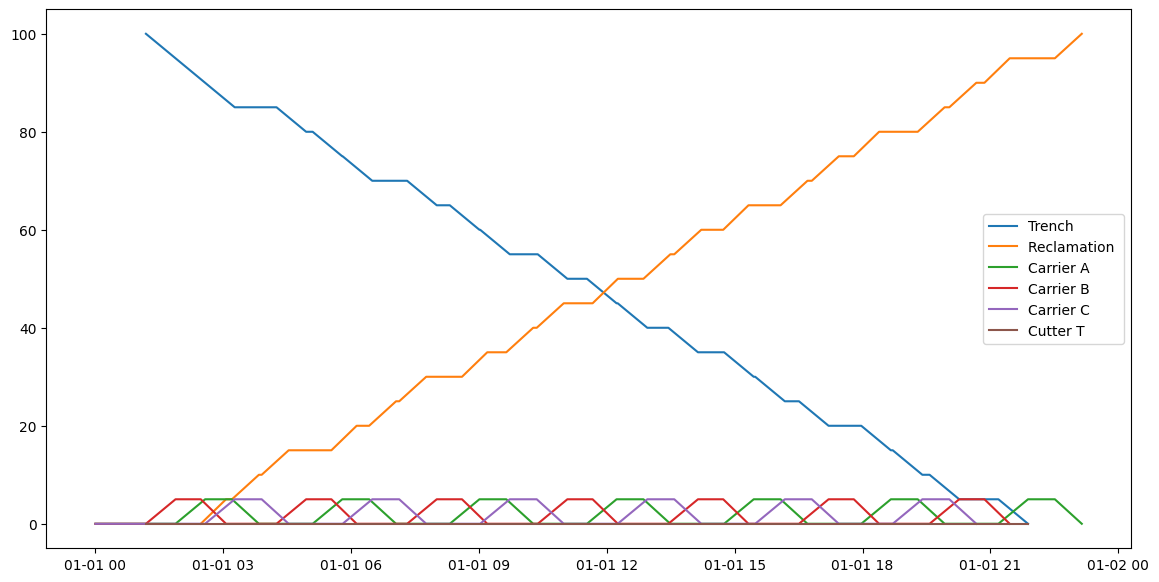

In [9]:
fig = get_step_chart([from_site, to_site, *vessels.values()])

# Compare multiple barge scenarios

In [10]:
def occupancy_analysis(vessels, cutter, activities, vessel_cost):
    data = []
    duration_theory_cutter = 0
    nr_trips_cutter = 0

# barges
    
    for i, vessel_name in enumerate(vessels):
        if vessel_name!=cutter_name:
            vessel = vessels[vessel_name]
            activity = activities[f'activity{i}']

            log = pd.DataFrame(vessel.log)
            sub_act = activity.sub_processes[0].sub_processes[-1] # last phase of SequentialActivity ..
            nr_trips = len(log[(log.ActivityID == sub_act.id) & (log.ActivityState == "STOP")]) # .. ended
            nr_trips_cutter += nr_trips

            duration_theory = 0
            for sub_act in activity.sub_processes[0].sub_processes:
                duration_theory+=sub_act.duration
                if hasattr(sub_act,'processor'):
                    if sub_act.processor.name==cutter_name:
                        duration_theory_cutter += sub_act.duration*nr_trips

            duration_actual = (log.Timestamp.max() - log.Timestamp.min()).total_seconds()
            data.append({
                'name':vessel.name, 
                '# trips':nr_trips, 
                'start': log.Timestamp.min(),
                'finish': log.Timestamp.max(),
                'duration actual': duration_actual,
                'cost':duration_actual*vessel_cost[vessel_name]/3600/24,
                'production actual':(nr_trips * sub_act.amount) / (duration_actual),
                'production theory': (sub_act.amount / (duration_theory)),
            })

# cutter
    
    log = pd.DataFrame(cutter.log)
    duration_actual_cutter = (log.Timestamp.max() - log.Timestamp.min()).total_seconds()
    data.append({
        'name':cutter_name, 
        '# trips':nr_trips_cutter, 
        'start': log.Timestamp.min(),
        'finish': log.Timestamp.max(),
        'duration actual': duration_actual_cutter,
        'cost':duration_actual_cutter*vessel_cost[cutter_name]/3600/24,
        'production actual':(total_amount) / (duration_actual_cutter),
        'production theory':(total_amount) / (duration_theory_cutter),
    })

    df = pd.DataFrame(data).sort_values(by=['production actual'],ascending=False)
    df['occupancy [%]'] = [round(x,1) for x in 100*df['production actual']/df['production theory']]
    df.set_index('name', inplace=True)
    
    print(f'Occupancy "{cutter_name}":', df.loc[cutter_name]['occupancy [%]'],'% Total cost',round(df['cost'].sum(),0))
    
    return df

In [11]:
results = []
occupancy = []
cost = []
finish, duration = [], []
n_barges = range(2,len(barge_names)) # +1 at least 1 barge
for i in n_barges:
    results.append(run(i,total_amount))
    
    vessels = results[-1]['vessels']
    activities = results[-1]['activities']
    sites = results[-1]['sites']
    
    cutter = vessels[cutter_name]
    
    df = occupancy_analysis(vessels, cutter, activities,vessel_cost)
    occupancy.append(df.loc[cutter_name]['occupancy [%]'])
    cost.append(df['cost'].sum())
    finish.append(df['finish'].max())
    duration.append((df['finish'].max() - df['start'].min()).total_seconds()/3600/24)
    display(df)

Occupancy "Cutter T": 44.7 % Total cost 48393.0


,# trips,start,finish,duration actual,cost,production actual,production theory,occupancy [%]
name,,,,,,,,
Cutter T,20,1970-01-01 01:09:18,1970-01-02 08:11:38,111740.0,32332.175926,0.000895,0.002000,44.7
Carrier B,10,1970-01-01 00:00:00,1970-01-02 06:44:56,110696.0,7687.222222,0.000452,0.000462,97.7
Carrier A,10,1970-01-01 00:00:00,1970-01-02 09:29:38,120578.0,8373.472222,0.000415,0.000422,98.4


Occupancy "Cutter T": 50.2 % Total cost 51246.0


,# trips,start,finish,duration actual,cost,production actual,production theory,occupancy [%]
name,,,,,,,,
Cutter T,25,1970-01-01 01:24:38,1970-01-02 05:03:58,99560.0,28807.870370,0.001004,0.002000,50.2
Carrier C,9,1970-01-01 00:00:00,1970-01-02 06:28:36,109716.0,7619.166667,0.000328,0.000329,99.7
Carrier B,8,1970-01-01 00:00:00,1970-01-02 05:13:38,105218.0,7306.805556,0.000304,0.000309,98.5
Carrier A,8,1970-01-01 00:00:00,1970-01-02 06:02:58,108178.0,7512.361111,0.000296,0.000306,96.7


Occupancy "Cutter T": 71.3 % Total cost 41098.0


,# trips,start,finish,duration actual,cost,production actual,production theory,occupancy [%]
name,,,,,,,,
Cutter T,24,1970-01-01 01:08:58,1970-01-01 21:00:18,71480.0,20682.870370,0.001399,0.001961,71.3
Carrier C,6,1970-01-01 00:00:00,1970-01-01 21:51:06,78666.0,5462.916667,0.000381,0.000397,96.1
Carrier A,7,1970-01-01 00:00:00,1970-01-01 22:09:16,79756.0,5538.611111,0.000351,0.000389,90.2
Carrier B,6,1970-01-01 00:00:00,1970-01-01 20:41:58,74518.0,5174.861111,0.000322,0.000332,97.1
Barge I,5,1970-01-01 00:00:00,1970-01-01 20:20:48,73248.0,4238.888889,0.000273,0.000296,92.3


Occupancy "Cutter T": 87.5 % Total cost 37183.0


,# trips,start,finish,duration actual,cost,production actual,production theory,occupancy [%]
name,,,,,,,,
Cutter T,22,1970-01-01 01:21:50,1970-01-01 17:33:26,58296.0,16868.055556,0.001715,0.001961,87.5
Carrier A,5,1970-01-01 00:00:00,1970-01-01 18:13:36,65616.0,4556.666667,0.000381,0.000406,93.9
Barge II,5,1970-01-01 00:00:00,1970-01-01 19:00:10,68410.0,3958.912037,0.000365,0.000387,94.3
Barge I,4,1970-01-01 00:00:00,1970-01-01 17:45:22,63922.0,3699.189815,0.000313,0.000359,87.2
Carrier B,4,1970-01-01 00:00:00,1970-01-01 15:55:20,57320.0,3980.555556,0.000279,0.000302,92.5
Carrier C,4,1970-01-01 00:00:00,1970-01-01 16:28:40,59320.0,4119.444444,0.000270,0.000302,89.4


Occupancy "Cutter T": 100.0 % Total cost 35016.0


,# trips,start,finish,duration actual,cost,production actual,production theory,occupancy [%]
name,,,,,,,,
Cutter T,21,1970-01-01 01:07:46,1970-01-01 15:09:26,50500.0,14612.268519,0.001980,0.001980,100.0
Carrier C,4,1970-01-01 00:00:00,1970-01-01 14:55:10,53710.0,3729.861111,0.000372,0.000463,80.3
Carrier B,4,1970-01-01 00:00:00,1970-01-01 16:28:10,59290.0,4117.361111,0.000337,0.000418,80.6
Barge II,4,1970-01-01 00:00:00,1970-01-01 13:30:32,48632.0,2814.351852,0.000329,0.000395,83.3
Barge III,3,1970-01-01 00:00:00,1970-01-01 13:17:54,47874.0,2770.486111,0.000313,0.000381,82.2
Carrier A,3,1970-01-01 00:00:00,1970-01-01 14:34:10,52450.0,3642.361111,0.000286,0.000377,75.9
Barge I,3,1970-01-01 00:00:00,1970-01-01 15:58:48,57528.0,3329.166667,0.000261,0.000372,70.0


Occupancy "Cutter T": 100.0 % Total cost 36794.0


,# trips,start,finish,duration actual,cost,production actual,production theory,occupancy [%]
name,,,,,,,,
Cutter T,22,1970-01-01 01:07:28,1970-01-01 15:00:48,50000.0,14467.592593,0.002000,0.002000,100.0
Extra 1,3,1970-01-01 00:00:00,1970-01-01 13:12:00,47520.0,2200.000000,0.000316,0.000402,78.6
Carrier B,3,1970-01-01 00:00:00,1970-01-01 13:55:10,50110.0,3479.861111,0.000299,0.000396,75.6
Carrier C,4,1970-01-01 00:00:00,1970-01-01 14:53:16,53596.0,3721.944444,0.000299,0.000396,75.3
Barge II,3,1970-01-01 00:00:00,1970-01-01 14:41:04,52864.0,3059.259259,0.000284,0.000381,74.5
Carrier A,3,1970-01-01 00:00:00,1970-01-01 12:27:20,44840.0,3113.888889,0.000268,0.000345,77.5
Barge I,3,1970-01-01 00:00:00,1970-01-01 16:36:10,59770.0,3458.912037,0.000251,0.000359,70.0
Barge III,3,1970-01-01 00:00:00,1970-01-01 15:48:08,56888.0,3292.129630,0.000211,0.000315,66.9


Occupancy "Cutter T": 100.0 % Total cost 39505.0


,# trips,start,finish,duration actual,cost,production actual,production theory,occupancy [%]
name,,,,,,,,
Cutter T,23,1970-01-01 01:07:32,1970-01-01 15:09:12,50500.0,14612.268519,0.001980,0.001980,100.0
Barge II,3,1970-01-01 00:00:00,1970-01-01 13:19:14,47954.0,2775.115741,0.000313,0.000442,70.7
Extra 1,3,1970-01-01 00:00:00,1970-01-01 14:07:52,50872.0,2355.185185,0.000295,0.000412,71.6
Barge I,3,1970-01-01 00:00:00,1970-01-01 11:58:24,43104.0,2494.444444,0.000278,0.000396,70.3
Carrier C,3,1970-01-01 00:00:00,1970-01-01 16:45:34,60334.0,4189.861111,0.000249,0.000356,69.9
Barge III,3,1970-01-01 00:00:00,1970-01-01 14:44:00,53040.0,3069.444444,0.000226,0.000334,67.7
Carrier B,3,1970-01-01 00:00:00,1970-01-01 15:19:54,55194.0,3832.916667,0.000217,0.000326,66.8
Carrier A,3,1970-01-01 00:00:00,1970-01-01 16:01:24,57684.0,4005.833333,0.000208,0.000302,69.0
Extra 2,2,1970-01-01 00:00:00,1970-01-01 13:01:16,46876.0,2170.185185,0.000171,0.000293,58.2


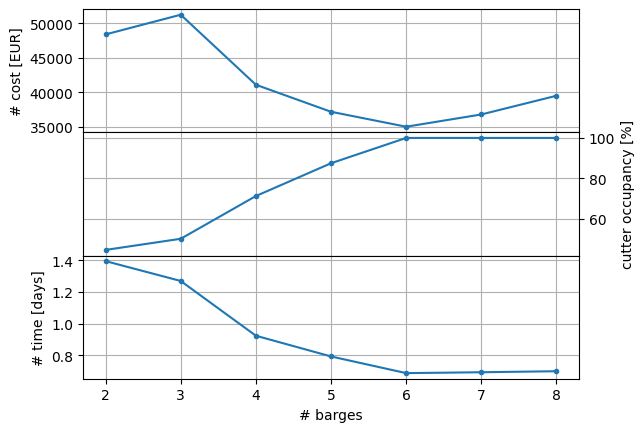

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure()
gs = fig.add_gridspec(3, hspace=0)
axs = gs.subplots(sharex=True)


axs[0].plot(n_barges,cost,'.-'), axs[0].set_ylabel('# cost [EUR]'),axs[0].grid();
# axs[0].set_xlabel('# barges');

axs[1].plot(n_barges,occupancy,'.-'), axs[1].set_ylabel('cutter occupancy [%]'),axs[1].grid();
# axs[1].set_xlabel('# barges');
axs[1].yaxis.set_label_position("right")
axs[1].yaxis.tick_right()

axs[2].plot(n_barges,duration,'.-'), axs[2].set_ylabel('# time [days]'),axs[2].grid();

axs[-1].set_xlabel('# barges');

## Visualize critical path of best scneario

For explanation of Critical Path see notebook 30

In [13]:
from openclsim.plot.critical_path import CpLog

In [14]:
i = 5 # many barges: close to 100% cutter config, small cost, fast delivery
vessels = results[i]['vessels']
activities = results[i]['activities']
sites = results[i]['sites']

cutter = vessels[cutter_name]
  
my_objects = list(vessels.values()) + list(sites.values())
my_activities = list(activities.values())
my_log = CpLog(list_objects=my_objects, list_activities=my_activities)
dependencies = my_log.get_dependencies_model_based()
# dependencies = my_log.get_dependencies_log_based()
cp = my_log.mark_critical_activities(dependencies)
df = occupancy_analysis(vessels, cutter, activities,vessel_cost)

t = f'{cutter_name} occupancy: ' + str(df.loc[cutter_name]['occupancy [%]'])
fig = get_gantt_chart(concepts=my_objects, critical_path=cp, id_map=activities, title=t, legend=False, ylabel='vesels')

Occupancy "Cutter T": 100.0 % Total cost 36794.0


# Export data  to BI

In [15]:
def export_concepts(concepts, namespace='', ofile=None,):
    """Save the concepts vities to a resolved csv file
    
    Concepts can be stored in 1 file (Sites and Vessels)
    or they can  be stored mixed together.

    Parameters
    ----------
    concepts
        concepts to be resolved and stored
    namespace
        str that will prepad the column names 'Name', 'ID', "Type".
        e.g. Vessel, Site or Concept
    ofile
        name of csv file to be exported
    id_map
        by default uuids are not resolved. id_map solves this at request:
        * a list of concepts
        * a manual id_map to resolve concept uuids to labels, e.g. {'uuid1':'vessel A'}
    """
    
    if isinstance(concepts,dict):
        concepts = [*concepts.values()] 
    
    df= {f'{namespace}Name':[x.name for x in concepts],
         f'{namespace}ID':[x.id for x in concepts],
         f'{namespace}Type':[type(x) for x in concepts]}
    
    df = pd.DataFrame(df)
    if ofile:
        df.to_csv(ofile, index=False)
    
    return df

def export_activities(activities, ofile=None, id_map=None):
    """Save the activities to a resolved csv file

    Parameters
    ----------
    activities
        activities to be resolved and stored
    ofile
        name of csv file to be exported
    id_map
        by default uuids are not resolved. id_map solves this at request:
        * a list of concepts
        * a manual id_map to resolve concept uuids to labels, e.g. {'uuid1':'vessel A'}
    """
    
    if isinstance(id_map, dict):
        id_map = [*id_map.values()]    
    if isinstance(id_map, list):
        id_map = {act.id: act.name for act in id_map} # needs to be recursive: flatten
    else:
        id_map = id_map if id_map else {}
    
    df = flatten(activities)
    
    df['ProcessorID']     = [x.processor.id   if hasattr(x,'processor')   else None for x in df['activity']]
    df['MoverID']         = [x.mover.id       if hasattr(x,'mover')       else None for x in df['activity']]
    df['OriginID']        = [x.origin.id      if hasattr(x,'origin')      else None for x in df['activity']]
    df['DestinationID']   = [x.destination.id if hasattr(x,'destination') else None for x in df['activity']]
    
    df['ProcessorName']   = [dict.get(id_map,x,'') for x in df['ProcessorID']]
    df['MoverName']       = [dict.get(id_map,x,'') for x in df['MoverID']]
    df['OriginName']      = [dict.get(id_map,x,'') for x in df['OriginID']]
    df['DestinationName'] = [dict.get(id_map,x,'') for x in df['DestinationID']]

    # manually set column order + exclude actual 'activity' object !
    
    keys  = ['ActivityID','ActivityName','ActivityType',
             'ParentId','ParentName','ParentLevel',
             'OriginID','OriginName',
             'DestinationID','DestinationName',
             'ProcessorID','ProcessorName',
             'MoverID', 'MoverName'
            ]
    
    df = pd.DataFrame(df)
        
    if ofile:
        df.to_csv(ofile, columns = keys, index=False)
    
    return df

In [16]:
export_concepts(sites, 'site', 'sites.csv')

,siteName,siteID,siteType
0,Trench,2a5636f9-c21a-43e8-bd4f-a8c5ddcfeb8a,<class '__main__.Site'>
1,Reclamation,f77c188d-8ecb-4700-981f-4961b130cc00,<class '__main__.Site'>


In [17]:
export_concepts(vessels, 'vessel', 'vessels.csv')

,vesselName,vesselID,vesselType
0,Carrier A,274c64d5-54ba-47f0-8292-d2435f8c98ad,<class '__main__.TransportProcessingResource'>
1,Carrier B,c7e23e6a-0d76-4fc8-9194-4600d106f148,<class '__main__.TransportProcessingResource'>
2,Carrier C,e29569df-d7b2-4383-8ca5-38d5c5c5b6cb,<class '__main__.TransportProcessingResource'>
3,Barge I,440f7d43-60fc-4694-88b0-02d7f662c7b0,<class '__main__.TransportProcessingResource'>
4,Barge II,ae75bd48-b45e-4b64-8d40-38f059d7e653,<class '__main__.TransportProcessingResource'>
5,Barge III,aff22831-ad5e-4f71-aeaf-a5734d321a75,<class '__main__.TransportProcessingResource'>
6,Extra 1,965871e8-95d9-41d1-ab17-f6e50e74a407,<class '__main__.TransportProcessingResource'>
7,Cutter T,993588ea-2ece-48dd-ab8a-09b046b36298,<class '__main__.TransportProcessingResource'>


In [18]:
Df = export_activities(activities, 'activities.csv', [*sites.values(), *vessels.values()])
Df

,ActivityID,ActivityName,ActivityType,ParentId,ParentName,ParentLevel,activity,ProcessorID,MoverID,OriginID,DestinationID,ProcessorName,MoverName,OriginName,DestinationName
0,4b0ebe41-0c72-4696-8032-a40fe6d5985d,while_sequential_activity_subcycle Carrier A,WhileActivity,None,,0,<openclsim.model.while_activity.WhileActivity ...,None,None,None,None,,,,
1,d182ae7a-1e7f-47cc-b85b-d7bc1f7ff35d,while_sequential_activity_subcycle Carrier B,WhileActivity,None,,0,<openclsim.model.while_activity.WhileActivity ...,None,None,None,None,,,,
2,b0151f12-77bc-4440-b9ec-c73a833ba788,while_sequential_activity_subcycle Carrier C,WhileActivity,None,,0,<openclsim.model.while_activity.WhileActivity ...,None,None,None,None,,,,
3,ed62cb70-854b-4fcc-a779-3d1c18d06e29,while_sequential_activity_subcycle Barge I,WhileActivity,None,,0,<openclsim.model.while_activity.WhileActivity ...,None,None,None,None,,,,
4,fc483dbe-d6e6-4e80-9503-727191e3095e,while_sequential_activity_subcycle Barge II,WhileActivity,None,,0,<openclsim.model.while_activity.WhileActivity ...,None,None,None,None,,,,
5,238b319d-00e4-4132-a2ff-189ae3caaa19,while_sequential_activity_subcycle Barge III,WhileActivity,None,,0,<openclsim.model.while_activity.WhileActivity ...,None,None,None,None,,,,
6,18597ce4-dca4-43eb-8b5b-f54c7811026b,while_sequential_activity_subcycle Extra 1,WhileActivity,None,,0,<openclsim.model.while_activity.WhileActivity ...,None,None,None,None,,,,
7,d58cf667-7176-404b-8a19-72ece1643bb8,sequential_activity_subcycle Carrier A,SequentialActivity,4b0ebe41-0c72-4696-8032-a40fe6d5985d,while_sequential_activity_subcycle Carrier A,1,<openclsim.model.sequential_activity.Sequentia...,None,None,None,None,,,,
8,260d5a53-4f53-45a6-9c08-a572b608f5f0,basic activity:Carrier A,BasicActivity,4b0ebe41-0c72-4696-8032-a40fe6d5985d,while_sequential_activity_subcycle Carrier A,2,<openclsim.model.basic_activity.BasicActivity ...,None,None,None,None,,,,
9,b7016833-7c4a-4494-ae07-851c3e6fb5d1,sailing empty:Carrier A,MoveActivity,4b0ebe41-0c72-4696-8032-a40fe6d5985d,while_sequential_activity_subcycle Carrier A,2,<openclsim.model.move_activity.MoveActivity ob...,None,274c64d5-54ba-47f0-8292-d2435f8c98ad,None,2a5636f9-c21a-43e8-bd4f-a8c5ddcfeb8a,,Carrier A,,Trench


In [19]:
set(Df['MoverName'])

{'',
 'Barge I',
 'Barge II',
 'Barge III',
 'Carrier A',
 'Carrier B',
 'Carrier C',
 'Extra 1'}

In [20]:
set(Df['ProcessorName'])

{'',
 'Barge I',
 'Barge II',
 'Barge III',
 'Carrier A',
 'Carrier B',
 'Carrier C',
 'Cutter T',
 'Extra 1'}

In [21]:
set(Df['OriginName'])

{'',
 'Barge I',
 'Barge II',
 'Barge III',
 'Carrier A',
 'Carrier B',
 'Carrier C',
 'Extra 1',
 'Trench'}

In [22]:
set(Df['DestinationName'])

{'',
 'Barge I',
 'Barge II',
 'Barge III',
 'Carrier A',
 'Carrier B',
 'Carrier C',
 'Extra 1',
 'Reclamation',
 'Trench'}

In [23]:
set(Df['ActivityType'])

{'BasicActivity',
 'MoveActivity',
 'SequentialActivity',
 'ShiftAmountActivity',
 'WhileActivity'}

In [25]:
set(Df['ActivityName'])

{'basic activity:Barge I',
 'basic activity:Barge II',
 'basic activity:Barge III',
 'basic activity:Carrier A',
 'basic activity:Carrier B',
 'basic activity:Carrier C',
 'basic activity:Extra 1',
 'loading:Barge I',
 'loading:Barge II',
 'loading:Barge III',
 'loading:Carrier A',
 'loading:Carrier B',
 'loading:Carrier C',
 'loading:Extra 1',
 'sailing empty:Barge I',
 'sailing empty:Barge II',
 'sailing empty:Barge III',
 'sailing empty:Carrier A',
 'sailing empty:Carrier B',
 'sailing empty:Carrier C',
 'sailing empty:Extra 1',
 'sailing full:Barge I',
 'sailing full:Barge II',
 'sailing full:Barge III',
 'sailing full:Carrier A',
 'sailing full:Carrier B',
 'sailing full:Carrier C',
 'sailing full:Extra 1',
 'sequential_activity_subcycle Barge I',
 'sequential_activity_subcycle Barge II',
 'sequential_activity_subcycle Barge III',
 'sequential_activity_subcycle Carrier A',
 'sequential_activity_subcycle Carrier B',
 'sequential_activity_subcycle Carrier C',
 'sequential_activity_s

In [26]:
Df[Df['ProcessorName']==cutter_name]

,ActivityID,ActivityName,ActivityType,ParentId,ParentName,ParentLevel,activity,ProcessorID,MoverID,OriginID,DestinationID,ProcessorName,MoverName,OriginName,DestinationName
10,30708dc9-4fc6-4975-9469-f61fc91d3728,loading:Carrier A,ShiftAmountActivity,4b0ebe41-0c72-4696-8032-a40fe6d5985d,while_sequential_activity_subcycle Carrier A,2,<openclsim.model.shift_amount_activity.ShiftAm...,993588ea-2ece-48dd-ab8a-09b046b36298,None,2a5636f9-c21a-43e8-bd4f-a8c5ddcfeb8a,274c64d5-54ba-47f0-8292-d2435f8c98ad,Cutter T,,Trench,Carrier A
16,d60c4a53-8541-4104-9910-0a642b466e0b,loading:Carrier B,ShiftAmountActivity,d182ae7a-1e7f-47cc-b85b-d7bc1f7ff35d,while_sequential_activity_subcycle Carrier B,2,<openclsim.model.shift_amount_activity.ShiftAm...,993588ea-2ece-48dd-ab8a-09b046b36298,None,2a5636f9-c21a-43e8-bd4f-a8c5ddcfeb8a,c7e23e6a-0d76-4fc8-9194-4600d106f148,Cutter T,,Trench,Carrier B
22,66869fcd-2737-4d9c-8b2d-d5e13651bb02,loading:Carrier C,ShiftAmountActivity,b0151f12-77bc-4440-b9ec-c73a833ba788,while_sequential_activity_subcycle Carrier C,2,<openclsim.model.shift_amount_activity.ShiftAm...,993588ea-2ece-48dd-ab8a-09b046b36298,None,2a5636f9-c21a-43e8-bd4f-a8c5ddcfeb8a,e29569df-d7b2-4383-8ca5-38d5c5c5b6cb,Cutter T,,Trench,Carrier C
28,f3ef7be0-df1c-46aa-9434-04813535723b,loading:Barge I,ShiftAmountActivity,ed62cb70-854b-4fcc-a779-3d1c18d06e29,while_sequential_activity_subcycle Barge I,2,<openclsim.model.shift_amount_activity.ShiftAm...,993588ea-2ece-48dd-ab8a-09b046b36298,None,2a5636f9-c21a-43e8-bd4f-a8c5ddcfeb8a,440f7d43-60fc-4694-88b0-02d7f662c7b0,Cutter T,,Trench,Barge I
34,d0746e8f-f231-4a5d-bff3-dda249bc112b,loading:Barge II,ShiftAmountActivity,fc483dbe-d6e6-4e80-9503-727191e3095e,while_sequential_activity_subcycle Barge II,2,<openclsim.model.shift_amount_activity.ShiftAm...,993588ea-2ece-48dd-ab8a-09b046b36298,None,2a5636f9-c21a-43e8-bd4f-a8c5ddcfeb8a,ae75bd48-b45e-4b64-8d40-38f059d7e653,Cutter T,,Trench,Barge II
40,934d7a40-61ae-42f2-89b1-15a009cf43ee,loading:Barge III,ShiftAmountActivity,238b319d-00e4-4132-a2ff-189ae3caaa19,while_sequential_activity_subcycle Barge III,2,<openclsim.model.shift_amount_activity.ShiftAm...,993588ea-2ece-48dd-ab8a-09b046b36298,None,2a5636f9-c21a-43e8-bd4f-a8c5ddcfeb8a,aff22831-ad5e-4f71-aeaf-a5734d321a75,Cutter T,,Trench,Barge III
46,abdf1cb7-c48b-4cf4-b2dc-081dbadfbace,loading:Extra 1,ShiftAmountActivity,18597ce4-dca4-43eb-8b5b-f54c7811026b,while_sequential_activity_subcycle Extra 1,2,<openclsim.model.shift_amount_activity.ShiftAm...,993588ea-2ece-48dd-ab8a-09b046b36298,None,2a5636f9-c21a-43e8-bd4f-a8c5ddcfeb8a,965871e8-95d9-41d1-ab17-f6e50e74a407,Cutter T,,Trench,Extra 1
